In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import os
import math
import sys

In [2]:
credit = pd.read_csv(r'C:\Users\Juliano\Repos\seminário_ds\SBAnational.csv', low_memory = False)

In [3]:
#!pip install uszipcode
import uszipcode
from uszipcode import SearchEngine
search = SearchEngine()

In [4]:
# rápido overview do dataset
#credit

In [5]:
# deletando valores duplicados
credit = credit.drop_duplicates(keep = 'first')
#Shape do dataset: 899164 linhas e 27 colunas
credit.shape

(899164, 27)

In [6]:
#Lista de colunas:
print(credit.dtypes.index)

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')


In [7]:
#Resumo do dataframe (count, mean, standart deviation, min, quartiles, max)
credit.describe()

,LoanNr_ChkDgt,Zip,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural
count,8.991640e+05,899164.000000,899164.000000,899164.000000,899164.000000,899028.000000,899164.000000,899164.000000,899164.000000,899164.000000
mean,4.772612e+09,53804.391241,398660.950146,110.773078,11.411353,1.280404,8.430376,10.797257,2753.725933,0.757748
std,2.538175e+09,31184.159152,263318.312759,78.857305,74.108196,0.451750,236.688165,237.120600,12758.019136,0.646436
min,1.000014e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.589758e+09,27587.000000,235210.000000,60.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,4.361439e+09,55410.000000,445310.000000,84.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,6.904627e+09,83704.000000,561730.000000,120.000000,10.000000,2.000000,1.000000,4.000000,1.000000,1.000000
max,9.996003e+09,99999.000000,928120.000000,569.000000,9999.000000,2.000000,8800.000000,9500.000000,99999.000000,2.000000


In [8]:
# verificação de dados faltantes
credit.isnull().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

In [9]:
# o objetivo é prever a variável "MIS_Value". De acordo com a documentação, "MIS_Status" tem duas variáveis: 
# status do empréstimo: charged off = CHGOFF, Paid in full = PIF
Counter(credit.MIS_Status).keys() # Se tem: "PIF", CHGOFF, nan nesta coluna

dict_keys(['P I F', 'CHGOFF', nan])

In [10]:
Counter(credit.MIS_Status).values() # "PIF": 739609, CHGOFF: 157558, nan:1997
# dados muito desbalanceados. Tentaremos não perder nossas linhas com valores CHGOFF enquanto limpamos o conjunto de dados.

dict_values([739609, 157558, 1997])

In [11]:
                                                    #####Primeiramente lidando com NAs.##### 
                                                          #Name, City, and State
# 4 colunas pertencem a informação do mutuário: Name, City, State, and Zip.
# nome é único e inútil, então pode-se remover a coluna inteira
credit = credit.drop(axis =1, columns = ['Name'])
# próximos são City e State. Não existem nan em zip, então pode-se imputar City e State usando valores de zip
# criando condições para um loop
cond = (credit.City.isnull()|credit.State.isnull())
missing_rows = credit[cond].index
# executando loop e imputando City e State usando zearch.by_zipcode function.
for i in missing_rows:
    zipcode = search.by_zipcode(credit.iloc[i,3]) # 3 corresponde a Zip code
    credit.iloc[i,1] = zipcode.major_city # 1 -> City
    credit.iloc[i,2] = zipcode.state # 2 -> State

#Checando como nan foram imputados. Ainda se tem 4 NAs. Um é zipcode = 0 
# os outros 3 não estão na lista da função search.by_zipcode. Podemos deletar estas linhas.
credit.isnull().sum()

LoanNr_ChkDgt             0
City                      4
State                     4
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

In [12]:
# próximas features com muitos NAs são Bank e BankState. 
equal = 0
non_equal = 0
for i in credit.index:
    if credit.State[i] == credit.BankState[i]:
        equal = equal + 1
    else:
        non_equal = non_equal +1
print(equal, non_equal)

473949 425215


In [13]:
#Como o objetivo é definir um caso padrão, verificarei se há casos padrão nas linhas em que o nome do banco e o estado do banco são desconhecidos.
cond_1 = credit.Bank.isnull()|credit.BankState.isnull()
missing_rows_1 = credit[cond_1].index
yes = 0
no = 0
for i in missing_rows_1:
    if credit.MIS_Status[i] == 'CHGOFF':
        yes = yes+1
    else:
        no = no +1
print(yes,no)

72 1494


In [14]:
# Removendo 'ChgOffDate'
credit = credit.drop(axis =1, columns = ['ChgOffDate'])

In [15]:
# Removendo Nas
credit = credit.dropna(axis =0, subset=['City','State','MIS_Status'])

loan_status = {'P I F': 1,'CHGOFF': 0} 
credit.MIS_Status = [loan_status[item] for item in credit.MIS_Status] 

Counter(credit.MIS_Status).keys() 

dict_keys([1, 0])

In [16]:
Counter(credit.MIS_Status).values() # contando valores 739607 = "1" contra 157556 = "0"

dict_values([739607, 157556])

In [17]:
# alterando tipo para float
currency = [19,20,22,23,24] 
for i in currency:
    credit[credit.columns[i]] = credit[credit.columns[i]].replace('[\$,]', '', regex=True).astype(float) 

In [18]:
# verificando novamente valores faltantes
credit.isnull().sum()

LoanNr_ChkDgt           0
City                    0
State                   0
Zip                     0
Bank                 1505
BankState            1512
NAICS                   0
ApprovalDate            0
ApprovalFY              0
Term                    0
NoEmp                   0
NewExist              134
CreateJob               0
RetainedJob             0
FranchiseCode           0
UrbanRural              0
RevLineCr            4520
LowDoc               2578
DisbursementDate     2175
DisbursementGross       0
BalanceGross            0
MIS_Status              0
ChgOffPrinGr            0
GrAppv                  0
SBA_Appv                0
dtype: int64

In [19]:
#verificando NewExist
Counter(credit.NewExist).keys() 

dict_keys([2.0, 1.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [20]:
Counter(credit.NewExist).values() # contando valores

dict_values([252559, 643443, 1027, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
# analisando outras features
cond_2 = credit[(credit['NewExist'] == 0) & (credit['RetainedJob'] >=1)].index
for i in cond_2:
    credit.loc[i,['NewExist']] = 1 

In [22]:
# alterando as condições
cond_3 = credit[(credit.NewExist.isnull()) & (credit['RetainedJob'] >=1)].index
for i in cond_3:
    credit.loc[i,['NewExist']] = 1    

In [23]:
# comparando os dados
credit[(credit['NewExist'] == 0) & (credit['MIS_Status'] == 0)] #60 linhas
credit[(credit.NewExist.isnull()) & (credit['MIS_Status'] == 0)] #1 linha

,LoanNr_ChkDgt,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
433834,4203385009,SITKA,AK,99835,NORTHRIM BANK,AK,561499,11-Aug-10,2010,82,...,2,N,N,11-Aug-10,15000.0,0.0,0,10718.0,15000.0,12750.0


In [24]:
# analisando os dados de FranchiseCode
Counter(credit.FranchiseCode).keys()

dict_keys([1, 0, 15100, 19755, 10656, 22470, 16267, 21425, 3490, 66320, 77175, 21400, 10495, 50949, 20550, 950, 78760, 84025, 50564, 68060, 10676, 10397, 23997, 51570, 70405, 81612, 36002, 16920, 67759, 81965, 39598, 75982, 90725, 9802, 17205, 23379, 80600, 22475, 10602, 78325, 401, 40472, 73675, 17998, 39700, 21420, 23000, 72590, 79140, 68021, 65925, 71456, 10622, 8380, 44081, 10528, 6410, 52000, 83882, 21780, 10734, 60227, 38510, 77174, 89769, 75385, 10615, 10556, 9050, 42520, 68020, 45455, 66910, 9800, 81630, 10720, 6560, 27765, 65140, 85100, 64985, 64960, 53250, 24850, 75710, 10643, 59450, 25650, 56480, 50040, 62343, 35706, 52956, 55120, 36680, 16310, 3515, 61400, 90703, 46413, 1350, 49952, 43700, 68150, 50028, 4516, 84535, 3512, 39238, 35300, 75985, 56837, 45479, 33570, 46408, 20728, 70130, 67750, 88660, 61901, 37000, 10729, 79950, 73900, 66690, 33550, 67400, 10691, 62753, 85150, 75900, 35705, 61900, 82360, 8047, 74820, 30207, 10200, 21790, 825, 34459, 15668, 19118, 90900, 43351, 

In [25]:
Counter(credit.FranchiseCode).values() # 845431 não Franchise Loans 

dict_values([637395, 208036, 70, 311, 11, 615, 34, 169, 219, 149, 6, 78, 1, 11, 223, 63, 3373, 173, 1034, 73, 34, 1, 3, 17, 51, 238, 7, 204, 70, 13, 129, 10, 4, 56, 308, 56, 21, 45, 3, 16, 12, 2, 212, 606, 88, 369, 111, 347, 659, 80, 122, 45, 42, 3, 47, 435, 57, 576, 87, 1001, 108, 7, 105, 241, 166, 79, 27, 13, 378, 6, 1921, 26, 134, 68, 191, 10, 107, 36, 194, 39, 5, 14, 220, 536, 202, 190, 122, 715, 31, 28, 5, 267, 40, 97, 164, 195, 11, 98, 2, 47, 260, 292, 14, 147, 1, 114, 196, 199, 39, 48, 7, 22, 49, 134, 9, 17, 145, 420, 44, 228, 53, 17, 98, 161, 21, 16, 7, 49, 20, 3, 160, 74, 21, 88, 7, 30, 3, 21, 7, 5, 28, 8, 18, 21, 20, 44, 5, 33, 138, 21, 100, 62, 4, 104, 13, 161, 68, 35, 31, 28, 140, 19, 261, 23, 19, 2, 10, 227, 57, 36, 45, 46, 104, 365, 4, 51, 54, 9, 68, 1, 29, 108, 34, 66, 9, 2, 7, 27, 77, 75, 5, 38, 146, 4, 62, 24, 85, 60, 150, 6, 127, 26, 125, 49, 2, 7, 1, 2, 9, 7, 12, 7, 275, 15, 32, 42, 174, 68, 4, 63, 47, 52, 16, 34, 94, 30, 197, 27, 39, 91, 51, 25, 2, 19, 196, 6, 2, 74

In [26]:
# verificando a suposição, se o Código de Franquia está com dígitos = Novo negócio
cond_4 = credit[(credit['FranchiseCode'] != 0) & (credit['FranchiseCode'] != 1)] 
Counter(cond_4.NewExist).values()
# Se tem
# 27940 rows - New Business
# 23725 rows - Exisitng Business
# 67 rows - NA in Existing Business

dict_values([27940, 23725, 67])

In [27]:
#Counter(credit.NewExist).keys() # unique values
#Counter(credit.NewExist).values() # count values 


#Primeiro, atribuirei NAs a valores 0 e eliminarei todos os NAs neste recurso.
cond_5 = credit[(credit['NewExist'] == 0)].index
for i in cond_5:
    credit.loc[i,['NewExist']] = np.nan #11 correspondem a NewExist
    
credit = credit.dropna(axis =0, subset=['NewExist'])

In [28]:
# valores faltantes
credit.isnull().sum()

LoanNr_ChkDgt           0
City                    0
State                   0
Zip                     0
Bank                 1503
BankState            1510
NAICS                   0
ApprovalDate            0
ApprovalFY              0
Term                    0
NoEmp                   0
NewExist                0
CreateJob               0
RetainedJob             0
FranchiseCode           0
UrbanRural              0
RevLineCr            4517
LowDoc               2578
DisbursementDate     2174
DisbursementGross       0
BalanceGross            0
MIS_Status              0
ChgOffPrinGr            0
GrAppv                  0
SBA_Appv                0
dtype: int64

In [29]:
# Decidi retirar o nome do banco e o estado do banco nesta fase. Minha ideia era usar o estado como um preditor, porque
#diferentes estados têm diferentes ambientes econômicos.
# De acordo com a documentação, o Estado do Mutuário é o Recurso certo a ser usado para esse objetivo.
#Além disso, o nome do banco (> 5000 nomes) como nome do mutuário é um valor exclusivo, portanto, também podemos excluí-lo.
#Columns "Data de desembolso", "DisbursementGross", "BalanceGross" e "ChgOffPrinGr"
#contain informações que são importantes depois que o padrão é declarado, portanto, não podemos usar essas colunas para prever
# riscos padrão. Eu os apago.
credit = credit.drop(axis =1, columns = ['Bank', 'BankState', 'DisbursementDate', 'DisbursementGross', 
                                         'BalanceGross','ChgOffPrinGr'])

In [30]:
Counter(credit.LowDoc).keys()

dict_keys(['Y', 'N', 'C', '1', nan, 'S', 'R', 'A', '0'])

In [31]:
Counter(credit.LowDoc).values()

dict_values([110046, 780227, 757, 1, 2578, 603, 74, 495, 1489])

In [32]:
from datetime import date
credit['ApprovalDate'] = credit['ApprovalDate'].astype(str)
credit['ApprovalDate'] = pd.to_datetime(credit['ApprovalDate'])

In [33]:
cond_6 = credit[(credit['LowDoc'] != "Y") & (credit['LowDoc'] != "N")]
cond_6

,LoanNr_ChkDgt,City,State,Zip,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
7413,1050326003,ST. NAZIANZ,WI,54232,333111,2006-02-16,2006,240,130,1.0,0,130,1,2,0,C,1,1306000.0,1306000.0
23459,1176096001,DEMING,NM,88031,722110,2006-02-27,2006,120,7,2.0,0,0,1,1,N,C,1,160000.0,120000.0
30877,1232806006,EL PASO,TX,79938,722213,2006-03-02,2006,120,5,2.0,0,0,8023,1,N,C,1,189000.0,141750.0
35740,1272576003,AVON LAKE,OH,44012,811192,2006-03-06,2006,252,2,2.0,0,0,1,1,N,C,1,1200000.0,900000.0
36376,1277995003,Martinsville,VA,24112,484110,2005-04-22,2005,83,1,1.0,2,1,1,2,Y,C,1,250000.0,125000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886336,9718424003,EL PASO,TX,79901,541620,2006-01-19,2006,60,16,1.0,0,0,1,1,Y,C,1,200000.0,150000.0
886363,9719294003,EL PASO,TX,79922,326199,2006-01-19,2006,84,71,1.0,0,0,1,1,N,C,1,2000000.0,1500000.0
887812,9755534000,EL PASO,TX,79925,238990,2006-01-23,2006,240,15,1.0,4,0,1,1,0,C,1,131000.0,131000.0
891829,9844504004,EL PASO,TX,79902,621310,2006-02-02,2006,84,3,2.0,0,0,1,1,N,C,1,135000.0,114750.0


In [34]:
Counter(cond_6.LowDoc).values()
Counter(cond_6.LowDoc).keys() 

dict_keys(['C', '1', nan, 'S', 'R', 'A', '0'])

In [35]:
Counter(cond_6.MIS_Status).values()

dict_values([4421, 1576])

In [36]:
low_doc = credit[credit['LowDoc'] == "Y"]

In [37]:
low_doc['GrAppv'].describe()

count     110046.000000
mean       68661.091816
std        37671.332829
min         4000.000000
25%        40000.000000
50%        60000.000000
75%       100000.000000
max      1000000.000000
Name: GrAppv, dtype: float64

In [38]:
low_doc['Term'].describe()

count    110046.000000
mean         87.698026
std          45.809016
min           0.000000
25%          60.000000
50%          84.000000
75%          93.000000
max         511.000000
Name: Term, dtype: float64

In [39]:
Counter(low_doc.MIS_Status).keys()
Counter(low_doc.MIS_Status).values() 

dict_values([100153, 9893])

In [40]:
cond_7 = cond_6[(cond_6['GrAppv'] <= 100000) & (cond_6['Term'] <= 93) & (cond_6['MIS_Status'] == 1)]
cond_7


,LoanNr_ChkDgt,City,State,Zip,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
49151,1380186001,EL PASO,TX,79912,531210,2006-03-16,2006,60,2,1.0,0,0,1,1,Y,C,1,50000.0,37500.0
66702,1503586004,EL PASO,TX,79936,541310,2006-03-27,2006,60,4,2.0,0,0,1,1,N,C,1,30000.0,25500.0
71166,1535204008,EL PASO,TX,79915,0,1997-09-10,1997,84,6,1.0,2,4,1,0,N,C,1,45000.0,36000.0
75024,1562824001,EL PASO,TX,79905,0,1997-09-19,1997,60,1,2.0,0,1,1,0,N,C,1,11000.0,8800.0
96102,1712804002,EL PASO,TX,79902,0,1997-12-02,1998,68,3,1.0,2,1,1,0,N,C,1,25000.0,20000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860458,9254924001,EL PASO,TX,79936,561730,2005-11-09,2006,60,19,1.0,0,0,1,1,Y,C,1,50000.0,42500.0
862620,9286494008,EL PASO,TX,79935,323110,2005-11-17,2006,36,13,1.0,0,0,1,1,Y,C,1,100000.0,85000.0
870592,9398784006,EL PASO,TX,79901,541810,2005-12-08,2006,75,8,1.0,0,0,1,1,N,C,1,75000.0,63750.0
879369,9541544008,EL PASO,TX,79922,444220,2005-12-29,2006,72,1,2.0,0,0,1,1,N,C,1,60000.0,51000.0


In [41]:
for i in cond_7.index:
    credit.loc[i,['LowDoc']] = 'Y'

In [42]:
cond_8 = credit[(credit['LowDoc'] != "Y") & (credit['LowDoc'] != "N")]
cond_8

,LoanNr_ChkDgt,City,State,Zip,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
7413,1050326003,ST. NAZIANZ,WI,54232,333111,2006-02-16,2006,240,130,1.0,0,130,1,2,0,C,1,1306000.0,1306000.0
23459,1176096001,DEMING,NM,88031,722110,2006-02-27,2006,120,7,2.0,0,0,1,1,N,C,1,160000.0,120000.0
30877,1232806006,EL PASO,TX,79938,722213,2006-03-02,2006,120,5,2.0,0,0,8023,1,N,C,1,189000.0,141750.0
35740,1272576003,AVON LAKE,OH,44012,811192,2006-03-06,2006,252,2,2.0,0,0,1,1,N,C,1,1200000.0,900000.0
36376,1277995003,Martinsville,VA,24112,484110,2005-04-22,2005,83,1,1.0,2,1,1,2,Y,C,1,250000.0,125000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886336,9718424003,EL PASO,TX,79901,541620,2006-01-19,2006,60,16,1.0,0,0,1,1,Y,C,1,200000.0,150000.0
886363,9719294003,EL PASO,TX,79922,326199,2006-01-19,2006,84,71,1.0,0,0,1,1,N,C,1,2000000.0,1500000.0
887812,9755534000,EL PASO,TX,79925,238990,2006-01-23,2006,240,15,1.0,4,0,1,1,0,C,1,131000.0,131000.0
891829,9844504004,EL PASO,TX,79902,621310,2006-02-02,2006,84,3,2.0,0,0,1,1,N,C,1,135000.0,114750.0


In [43]:
for i in cond_8.index:
    credit.loc[i,'LowDoc'] = np.nan

credit = credit.dropna(axis =0, subset=['LowDoc'])

In [44]:
Counter(credit.RevLineCr).keys()
Counter(credit.RevLineCr).values()

dict_values([415133, 256971, 200190, 15191, 4289, 11, 1, 22, 2, 1, 6, 14, 1, 1, 1, 1, 1, 1, 1])

In [45]:
cond_9 = credit[(credit['RevLineCr'] != "Y") & (credit['RevLineCr'] != "N")] #277188 rows

In [46]:
Counter(cond_9.MIS_Status).values() 

dict_values([231537, 44978])

In [47]:
RevLine_yes = credit[credit['RevLineCr'] == "Y"]
RevLine_no = credit[credit['RevLineCr']  == "N"]

In [48]:
RevLine_yes.Term.describe() 

count    200190.000000
mean         61.533938
std          27.128074
min           0.000000
25%          39.000000
50%          75.000000
75%          84.000000
max         312.000000
Name: Term, dtype: float64

In [49]:
RevLine_no.Term.describe() 

count    415133.000000
mean        125.915061
std          82.077373
min           0.000000
25%          60.000000
50%          84.000000
75%         180.000000
max         527.000000
Name: Term, dtype: float64

In [50]:
RevLine_no.NoEmp.describe()

count    415133.000000
mean         14.430156
std          87.034973
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max        9999.000000
Name: NoEmp, dtype: float64

In [51]:
RevLine_yes.NoEmp.describe()

count    200190.000000
mean          6.845717
std          40.030355
min           0.000000
25%           2.000000
50%           3.000000
75%           6.000000
max        8000.000000
Name: NoEmp, dtype: float64

In [53]:
credit = credit.drop(axis =1, columns = ['Zip','LoanNr_ChkDgt','ApprovalDate', 'ApprovalFY','RevLineCr','SBA_Appv'])

In [55]:
Counter(credit.State).keys() .

dict_keys(['IN', 'OK', 'FL', 'CT', 'NJ', 'NC', 'IL', 'RI', 'TX', 'VA', 'TN', 'AR', 'MN', 'MO', 'MA', 'CA', 'SC', 'LA', 'IA', 'OH', 'KY', 'MS', 'NY', 'MD', 'PA', 'OR', 'ME', 'KS', 'MI', 'AK', 'WA', 'CO', 'MT', 'WY', 'UT', 'NH', 'WV', 'ID', 'AZ', 'NV', 'WI', 'NM', 'GA', 'ND', 'VT', 'AL', 'NE', 'SD', 'HI', 'DE', 'DC'])

In [56]:
def first_two(d):
    if d <= 0:
        return 0
    return (d // 10 ** (int(math.log(d, 10)) - 1))

def point_def(rate):
    if rate <= 12:
        return 5
    elif  12 < rate <= 17: 
        return 4
    elif 17 < rate <= 21:
        return 3
    elif 21 < rate <= 25:
        return 2
    elif rate > 25:
        return 1

In [57]:
def apply_score(i):
    sector_default = {21 : 8, 11 : 9, 55 : 10, 62:10, 22:14, 92:15,54:19, 42:19,31:19,32:16,33:14,81:20,71:21,72:22,44:22,45:23,23:23,56:24,61:24,51:25,48:27,49:23,52:28,53:29}
    if i > 0:
        defrate = None
        if i in sector_default:
            defrate = sector_default[i]
            return point_def(defrate)
    return 0

In [58]:
credit['Sector_Points'] = credit.NAICS.apply(first_two).apply(apply_score)

In [59]:
def apply_score_state(i):
    state_default = {'MT':8, 'ND': 8, 'WY':8, 'SD':8, 'VT':8, 'ME':10,'NH':10, 'NM':10, 'AK':10, 'WA':13,'AD':13, 'MN':13, 
                     'WI':13, 'IA':13,'NE':13, 'KS':13, 'MA':13,'CT':13,'RI':13,'PA':13, 'NV':23, 'IL':23, 'MI':23, 'KY':23,
                     'GA':23, 'FL':28}
    temp_defrate = None
    average_def_rate = 18
    if i in state_default:
        temp_defrate = state_default[i]
        return point_def(temp_defrate)
    return point_def(average_def_rate)

In [60]:
credit['State_Points'] = credit.State.apply(apply_score_state)

In [61]:
credit = credit.drop(axis =1, columns = ['City', 'State', 'NAICS'])

In [62]:
def yes_no(i):
    if i > 0:
        return 1
    return 0

credit.Term = credit.Term//12
credit['IscreateJob'] = credit.CreateJob.apply(yes_no)
credit['IsRetained']  = credit.RetainedJob.apply(yes_no)
credit['IsFranchise'] = credit.FranchiseCode.apply(yes_no)

In [63]:
#I will recode LowDoc Yes and No to 1 and 0.
def lowdoc(i):
    if i == "Y":
        return 1
    return 0
credit.LowDoc = credit.LowDoc.apply(lowdoc)

In [64]:
Counter(credit.UrbanRural).keys()
Counter(credit.UrbanRural).values() 

dict_values([320543, 466879, 104416])

In [65]:
credit = credit.drop(axis =1, columns = ['FranchiseCode'])

In [66]:
credit

,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,LowDoc,MIS_Status,GrAppv,Sector_Points,State_Points,IscreateJob,IsRetained,IsFranchise
0,7,4,2.0,0,0,0,1,1,60000.0,2,3,0,0,1
1,5,2,2.0,0,0,0,1,1,40000.0,2,3,0,0,1
2,15,7,1.0,0,0,0,0,1,287000.0,5,3,0,0,1
3,5,2,1.0,0,0,0,1,1,35000.0,0,3,0,0,1
4,20,14,1.0,7,7,0,0,1,229000.0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,5,6,1.0,0,0,0,0,1,70000.0,2,3,0,0,1
899160,5,6,1.0,0,0,0,0,1,85000.0,2,3,0,0,1
899161,9,26,1.0,0,0,0,0,1,300000.0,4,3,0,0,1
899162,5,6,1.0,0,0,0,1,0,75000.0,0,3,0,0,1


C:\Users\Juliano\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


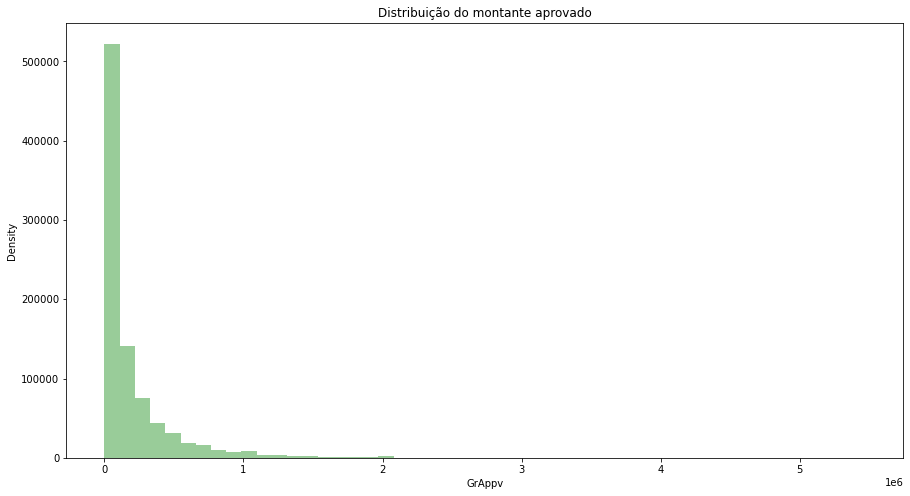

In [67]:
plt.figure(figsize=(15, 8))
sns.distplot(credit.GrAppv, color="g", kde=False)
plt.ylabel('Density')
plt.title('Distribuição do montante aprovado')
plt.show()

<AxesSubplot:xlabel='MIS_Status', ylabel='GrAppv'>

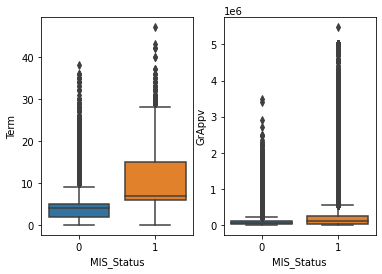

In [68]:
plt.subplot(1, 2, 1)
sns.boxplot( x='MIS_Status', y='Term', data = credit)

plt.subplot(1, 2, 2)
sns.boxplot( x='MIS_Status', y='GrAppv', data = credit)

In [94]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 60
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [96]:
from IPython.core.display  import HTML
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\Juliano\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [71]:
#Fix skewness of GrAppv using log
credit['GrAppv'] = np.log(credit['GrAppv']) 

C:\Users\Juliano\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


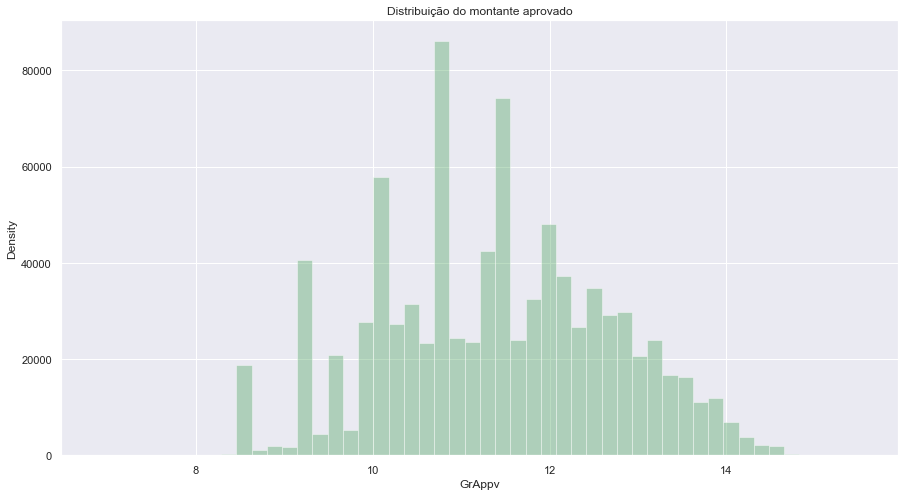

In [72]:
#As we can see, there is skewness.
plt.figure(figsize=(15, 8))
sns.distplot(credit.GrAppv, color="g", kde=False)
plt.ylabel('Density')
plt.title('Distribuição do montante aprovado')
plt.show()

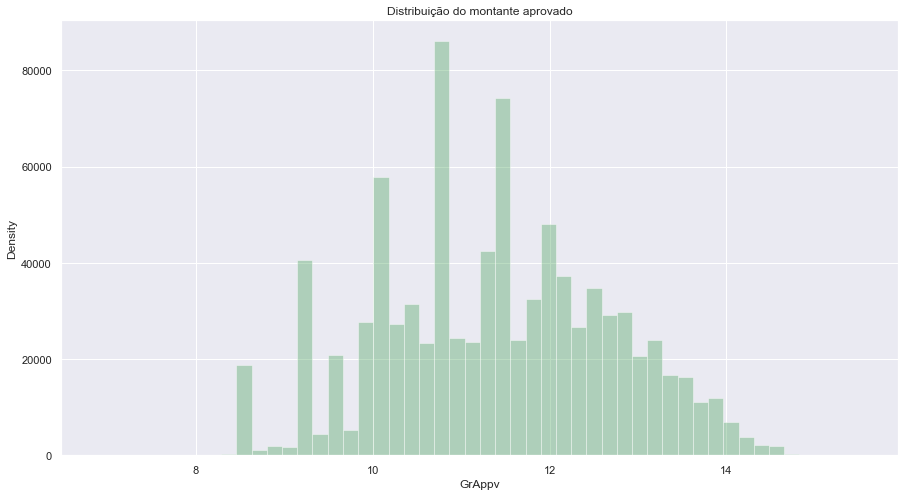

In [73]:
plt.figure(figsize=(15, 8))
sns.distplot(credit.GrAppv, color="g", kde=False)
plt.ylabel('Density')
plt.title('Distribuição do montante aprovado')
plt.show()

In [74]:
from sklearn.model_selection import train_test_split
y = credit.MIS_Status
X = credit.drop(['MIS_Status'], axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.30, random_state=0)

In [75]:
from sklearn.impute import SimpleImputer 
my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_sc =scaler.fit_transform(train_X)
test_sc = scaler.transform(test_X)

In [80]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
train_model = model.fit(train_sc, train_y)

In [87]:
#previsão
from sklearn.metrics import classification_report
pred = train_model.predict(test_X)
print('Report Random Forest %r' % (classification_report(test_y, pred)))

C:\Users\Juliano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Juliano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Report Random Forest '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00     46556\n           1       0.83      1.00      0.90    220996\n\n    accuracy                           0.83    267552\n   macro avg       0.41      0.50      0.45    267552\nweighted avg       0.68      0.83      0.75    267552\n'


C:\Users\Juliano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
# percentual de acurácia
from sklearn.metrics import accuracy_score
print("Accurácia do modelo: %.2f" % (accuracy_score(test_y, pred) * 100))

Accurácia do modelo: 82.60


In [98]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, pred)

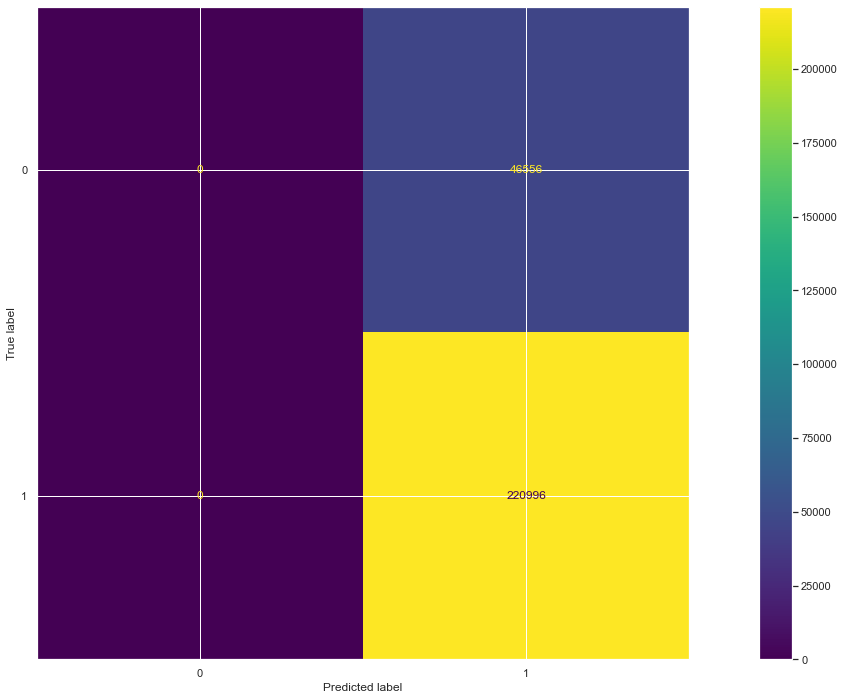

In [99]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay(cm).plot()